In [1]:
#Hello Cameron, This notebook calculates the EOF/PCA Analysis for ERRSST
#the framework of this code is provided from Harrison Tran @University of Wisconsin Madison: hktran3@wisc.edu

#import packages 
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime

#For Map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker 
from matplotlib.patches import Rectangle
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#Stuff for Meteorological calculations 
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

#Next thing: we need to know open up every file in the Dean Directory and loop through them!
import glob
import pandas as pd

#For stats
from scipy.stats import skew, norm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import cartopy.crs as ccrs

In [2]:
#First we open up the file path
filepath = '/Users/cameronmasiello/Desktop/Yearly_Sea_Surface_Larson/sst.mon*.nc'

#Find all netCDF files that match the pattern
datafiles_avg = sorted(glob.glob(filepath))

print(datafiles_avg[0])

#Open and combine the files along the 'time' dimension
dataset_avg = xr.open_dataset(datafiles_avg[0])

#Review the combined dataset
print(dataset_avg)

/Users/cameronmasiello/Desktop/Yearly_Sea_Surface_Larson/sst.mon.ltm.1991-2020.nc
<xarray.Dataset>
Dimensions:             (lat: 89, lon: 180, time: 12, nbnds: 2)
Coordinates:
  * lat                 (lat) float32 88.0 86.0 84.0 82.0 ... -84.0 -86.0 -88.0
  * lon                 (lon) float32 0.0 2.0 4.0 6.0 ... 354.0 356.0 358.0
  * time                (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:0...
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) datetime64[ns] ...
    sst                 (time, lat, lon) float32 ...
    valid_yr_count      (time, lat, lon) float32 ...
Attributes: (12/38)
    climatology:                    Climatology is based on 1971-2000 SST, Xu...
    description:                    In situ data: ICOADS2.5 before 2007 and N...
    keywords_vocabulary:            NASA Global Change Master Directory (GCMD...
    keywords:                       Earth Science > Oceans > Ocean Temperatur...
    instrument:           

/opt/anaconda3/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [3]:
# First we open up the file path
filepath = '/Users/cameronmasiello/Desktop/Yearly_Sea_Surface_Larson/sst.mnmean*.nc'

# Find all netCDF files that match the pattern
datafiles = sorted(glob.glob(filepath))

# Open and combine the files along the 'time' dimension
dataset = xr.open_mfdataset(datafiles, combine='by_coords')

# Subset the dataset to only include data from 1960 to 2024
dataset_subset = dataset.sel(time=slice('1960-01-01', '2024-12-31'))

In [4]:
###################################################################################################
#our data is monthly, so we will have to to take monthly averages! 

# This will calculate the mean SST for each calendar month over the entire time period
climatology = dataset_avg.groupby('time.month').mean('time')

# Step 2: Calculate Anomalies
# This subtracts the climatology from the original SST data to find the anomalies
anomalies = dataset_subset.groupby('time.month') - climatology

/opt/anaconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]


In [5]:
anomalies

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 771)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2024-03-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>

In [6]:
#Slice the data to only look at the North Atlantic
north_pacific = anomalies.sel(lat=slice(70, 20), lon=slice(140, 260))

In [7]:
#now start EOF analysis

#Select the 'SST' DataArray from the Dataset
sst_anomalies = north_pacific['sst']

#Perform polynomial fit (of degree 1 for linear trend) on the 'SST' DataArray
polyfit_results = sst_anomalies.polyfit(dim='time', deg=1)

#Extract the coefficients
coeffs = polyfit_results.polyfit_coefficients

#Evaluate the polynomial (the trend) at the given time coordinates
trend = xr.polyval(anomalies['time'], coeffs)

#Subtract the trend to detrend the data
detrended = sst_anomalies - trend

#Normalize by standard deviation
normalized_field = detrended / detrended.std('time')

#now we weight our field so higher latitudes are weighted based on their smaller spatial contribution
weighted_field = normalized_field * np.sqrt(np.cos(np.radians(normalized_field.lat)))

#finally, fill data points that are nan's with 0 values
weighted_field = weighted_field.fillna(0)

In [8]:
#This function was provided by Harrison:

def eof_spatial_analysis(field, n):
    """
    Given a spatial field [field] with dimensions (samples, x1, x2), compute the [n] leading eigenvectors, eigenvalues, 
    and principal components.
    """
    # Flatten array to form state sampled through the sampling dimension
    a, b, c = np.shape(field.values)  # Save dimensions of field
    state = field.values.reshape(a, b*c)

    # SVD decomposition of the state matrix
    U, S, V = LA.svd(state, full_matrices=False)

    eofs = V[:n, :].reshape(n, b, c)
    pcs = U[:, :n] * S[:n]
    evs = S[:n]**2

    # Normalize PCs
    pcs = (pcs - np.mean(pcs, axis=0)) / np.std(pcs, axis=0)

    return eofs, pcs, evs

# Now use the function to get the first 4 EOFs, PCs, and eigenvalues
eofs, pcs, evs = eof_spatial_analysis(weighted_field, 4)

/opt/anaconda3/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [26]:
#This calculates the EOF in terms of °C/Standard Deviation of SST Anomaly Data
eof_num = 1  # Index for the first EOF and PC

#Retrieve the original field data (this should be the data in units of °C before detrending and normalization)
#It's important that this data has the same spatial and temporal dimensions as the 'weighted_field' used in eof_spatial_analysis
state_orig = sst_anomalies.values  # 'original_field' should be the original SST data in °C
a, b, c = state_orig.shape

#Flatten the original state for projection
state_orig_flat = state_orig.reshape(a, b*c)

#Select the corresponding PC for the EOF pattern you want to visualize and standardize it
pc = pcs[:, eof_num - 1]
pc_std = (pc - np.mean(pc)) / np.std(pc)

#Project the standardized PC onto the EOF pattern
dn = (1.0 / np.size(state_orig_flat, axis=0)) * np.dot(pc_std, state_orig_flat)

#Reshape the result back to the original spatial dimensions
dnplot_1 = dn.reshape(b, c)

In [27]:
eofs_ds = xr.Dataset({
    'eof': xr.DataArray(eofs, 
                        coords={'mode': np.arange(1, 5), 
                                'lat': weighted_field.lat, 
                                'lon': weighted_field.lon}, 
                        dims=['mode', 'lat', 'lon']).assign_attrs({'name': 'EOF Spatial Pattern'}),
    
    'pc': xr.DataArray(pcs, 
                       coords={'time': detrended.time, 
                               'mode': np.arange(1, 5)}, 
                       dims=['time', 'mode']).assign_attrs({'name': 'Principal component timeseries'}),
    
    'pve': xr.DataArray(evs / np.sum(evs), 
                        coords={'mode': np.arange(1, 5)}, 
                        dims=['mode']).assign_attrs({'name': 'Percent variance explained'})
})

In [31]:
#now, we gonna make a beautiful map of the North Atlantic

def create_map_background():
    dataproj = ccrs.PlateCarree()
    fig= plt.figure(figsize=(64, 20))
    #ax = plt.subplot(111, projection=dataproj)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_global()
    ax.set_extent([140, -100 + 360, 20, 70], ccrs.PlateCarree())
    ax.coastlines('50m', linewidth=1.5)
    ax.add_feature(cfeature.STATES, linewidth=1.0)
    ax.add_feature(cfeature.BORDERS, linewidth=1.0)
    gl = ax.gridlines(color='gray',alpha=0.5,draw_labels=True) 
    gl.xlabels_top, gl.ylabels_right = False, False
    gl.xlabel_style, gl.ylabel_style = {'fontsize': 16}, {'fontsize': 16}
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 91, 10))
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    gl.yformatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(gl.xformatter)
    ax.yaxis.set_major_formatter(gl.yformatter)
    ax.stock_img()
    return fig, ax

In [32]:
lonsEOF = eofs_ds['lon']
latsEOF = eofs_ds['lat']

/var/folders/d_/plphgc7j2qdgppj6smtbjncc0000gn/T/ipykernel_2304/3432629510.py:17: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,


Text(0.0, 1.0, 'EOF1 North Pacifc ERSSTv5 (1960-2023)')

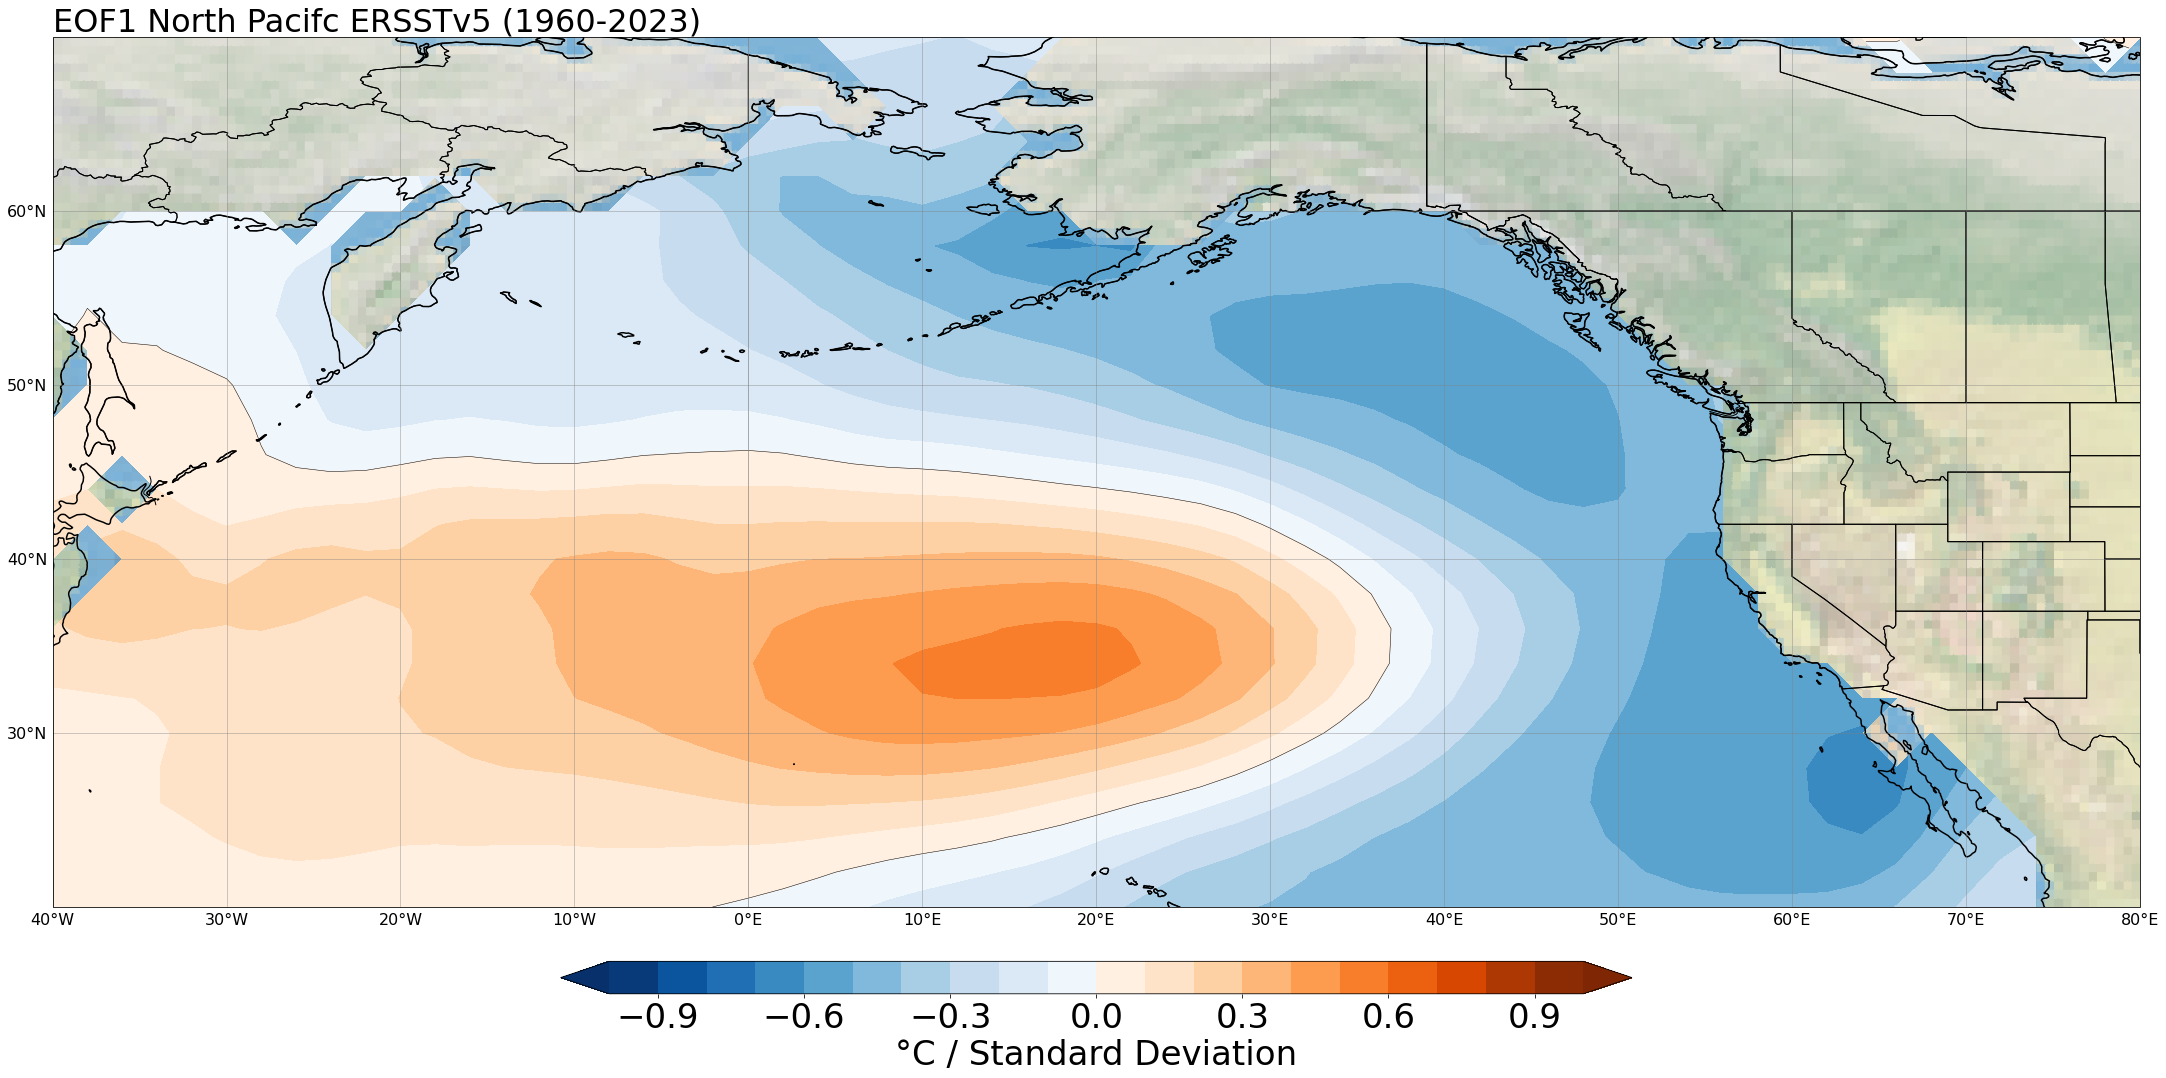

In [33]:
fig, ax = create_map_background()

bottom = cm.get_cmap('Oranges', 128)
top = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 50)),
                       bottom(np.linspace(0, 1, 50))))

newcmp = ListedColormap(newcolors, name='OrangeBlue')

css = plt.contourf(lonsEOF, latsEOF, dnplot_1,
                 levels = np.arange(-1, 1.1, .1),  # Adjust levels appropriately
                 cmap=newcmp,
                 transform=ccrs.PlateCarree(),  # specify the data's projection
                 extend='both')

cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,
                    extend ='both')

#Set the colorbar tick label size
cbar.ax.tick_params(labelsize=34) 

cbar.ax.set_xlabel('°C / Standard Deviation', fontsize = 34)

contourdifSSTglobeAnomaly = plt.contour(lonsEOF, latsEOF, dnplot_1, 
                             levels=np.arange(-1, 1, 1),  # Choose appropriate contour levels
                             linestyles='-', linewidths=0.5, colors='k',
                             transform=ccrs.PlateCarree())

plt.title(f'EOF1 North Pacifc ERSSTv5 (1960-2023)', loc='left',fontsize = 32)
#plt.title(f'Product By: Cameron Masiello', loc='right',fontsize = 32)

In [34]:
#This calculates the EOF in terms of °C/Standard Deviation of SST Anomaly Data
eof_num = 2  # Index for the first EOF and PC

#Retrieve the original field data (this should be the data in units of °C before detrending and normalization)
#It's important that this data has the same spatial and temporal dimensions as the 'weighted_field' used in eof_spatial_analysis
state_orig = sst_anomalies.values  # 'original_field' should be the original SST data in °C
a, b, c = state_orig.shape

#Flatten the original state for projection
state_orig_flat = state_orig.reshape(a, b*c)

#Select the corresponding PC for the EOF pattern you want to visualize and standardize it
pc = pcs[:, eof_num - 1]
pc_std = (pc - np.mean(pc)) / np.std(pc)

#Project the standardized PC onto the EOF pattern
dn = (1.0 / np.size(state_orig_flat, axis=0)) * np.dot(pc_std, state_orig_flat)

#Reshape the result back to the original spatial dimensions
dnplot_2 = dn.reshape(b, c)

/var/folders/d_/plphgc7j2qdgppj6smtbjncc0000gn/T/ipykernel_2304/390085224.py:17: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,


Text(0.0, 1.0, 'EOF2 North Pacifc ERSSTv5 (1960-2023)')

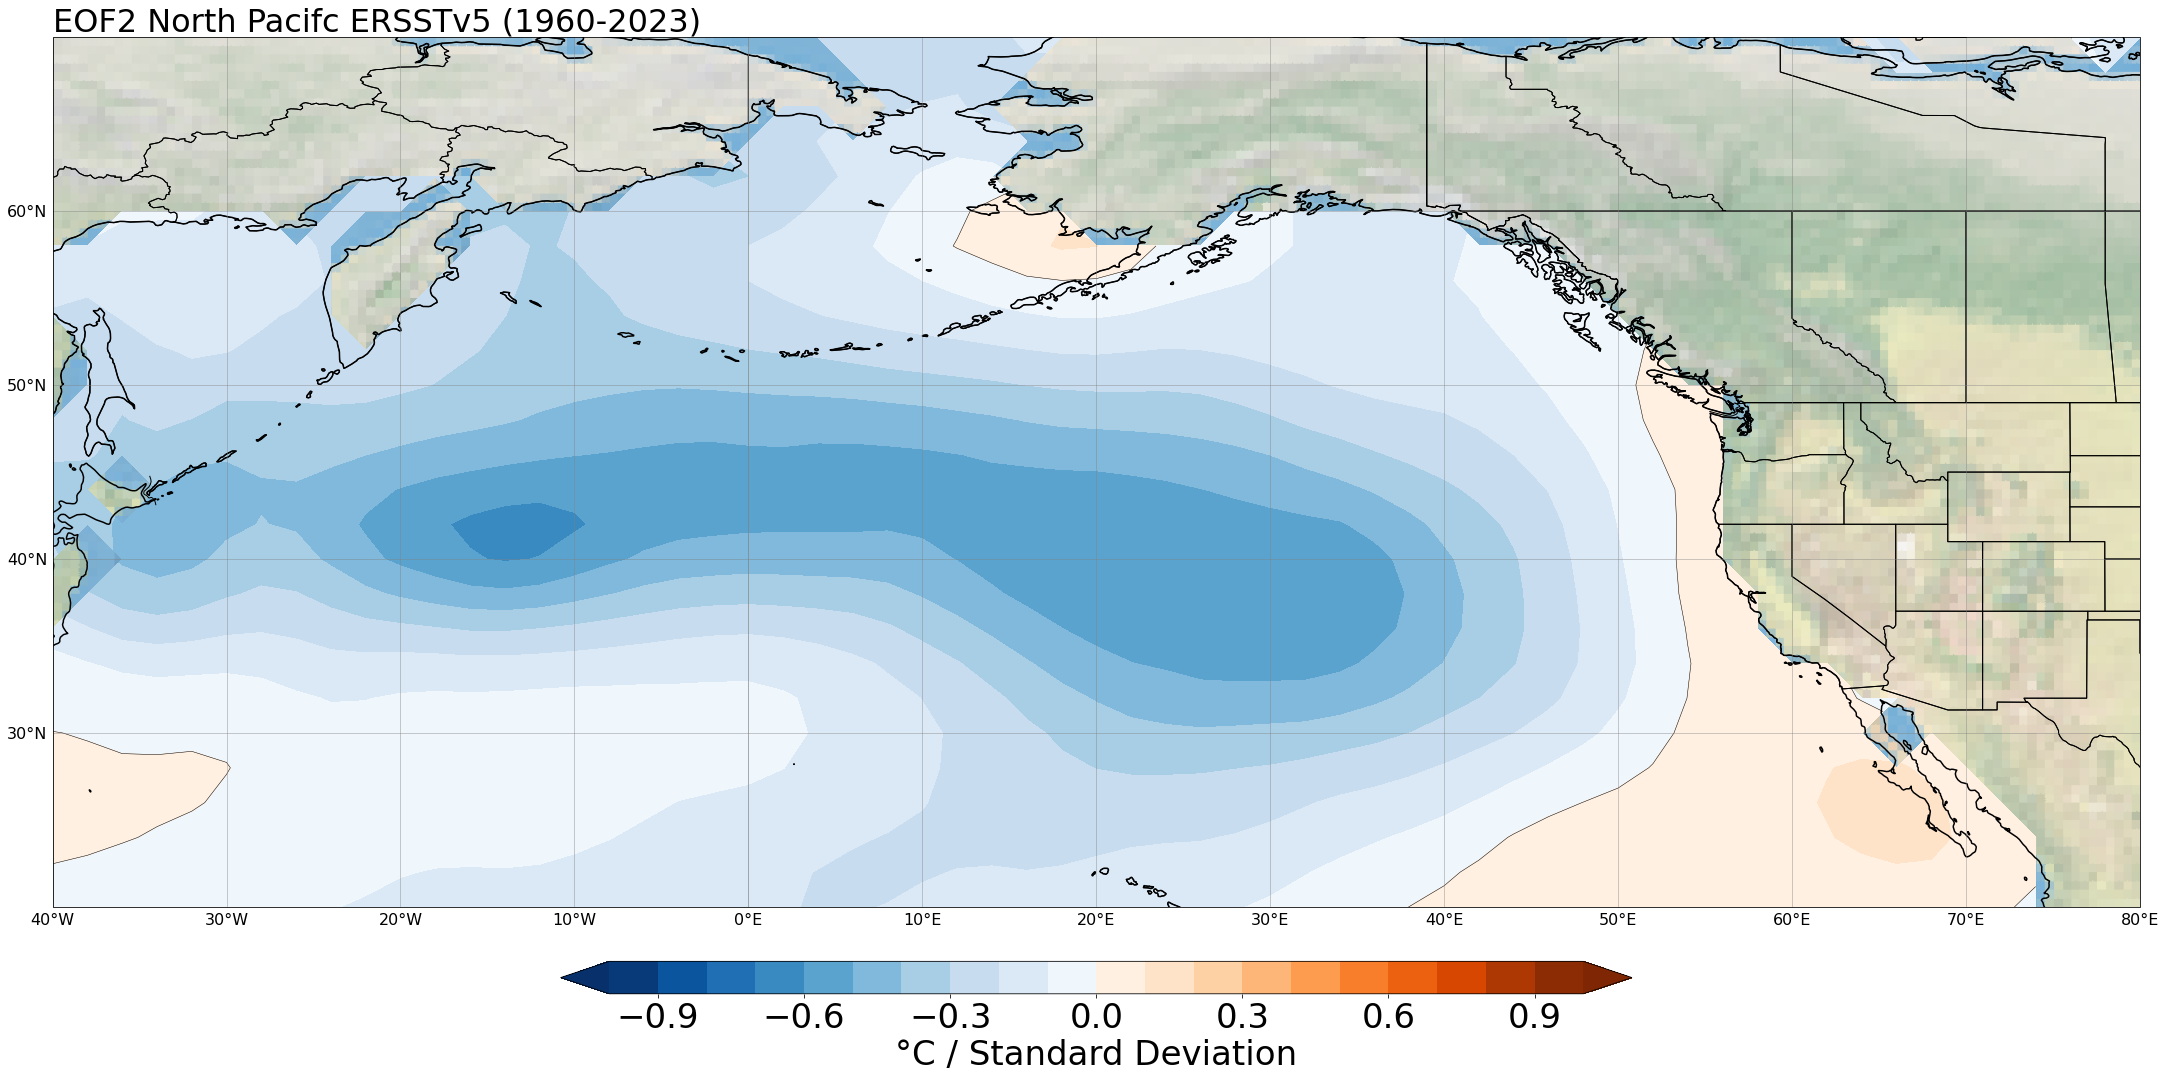

In [35]:
fig, ax = create_map_background()

bottom = cm.get_cmap('Oranges', 128)
top = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 50)),
                       bottom(np.linspace(0, 1, 50))))

newcmp = ListedColormap(newcolors, name='OrangeBlue')

css = plt.contourf(lonsEOF, latsEOF, dnplot_2,
                 levels = np.arange(-1, 1.1, .1),  # Adjust levels appropriately
                 cmap=newcmp,
                 transform=ccrs.PlateCarree(),  # specify the data's projection
                 extend='both')

cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,
                    extend ='both')

#Set the colorbar tick label size
cbar.ax.tick_params(labelsize=34) 

cbar.ax.set_xlabel('°C / Standard Deviation', fontsize = 34)

contourdifSSTglobeAnomaly = plt.contour(lonsEOF, latsEOF, dnplot_2, 
                             levels=np.arange(-1, 1, 1),  # Choose appropriate contour levels
                             linestyles='-', linewidths=0.5, colors='k',
                             transform=ccrs.PlateCarree())

plt.title(f'EOF2 North Pacifc ERSSTv5 (1960-2023)', loc='left',fontsize = 32)
#plt.title(f'Product By: Cameron Masiello', loc='right',fontsize = 32)

In [37]:
#This calculates the EOF in terms of °C/Standard Deviation of SST Anomaly Data
eof_num = 3  # Index for the first EOF and PC

#Retrieve the original field data (this should be the data in units of °C before detrending and normalization)
#It's important that this data has the same spatial and temporal dimensions as the 'weighted_field' used in eof_spatial_analysis
state_orig = sst_anomalies.values  # 'original_field' should be the original SST data in °C
a, b, c = state_orig.shape

#Flatten the original state for projection
state_orig_flat = state_orig.reshape(a, b*c)

#Select the corresponding PC for the EOF pattern you want to visualize and standardize it
pc = pcs[:, eof_num - 1]
pc_std = (pc - np.mean(pc)) / np.std(pc)

#Project the standardized PC onto the EOF pattern
dn = (1.0 / np.size(state_orig_flat, axis=0)) * np.dot(pc_std, state_orig_flat)

#Reshape the result back to the original spatial dimensions
dnplot_3 = dn.reshape(b, c)

/var/folders/d_/plphgc7j2qdgppj6smtbjncc0000gn/T/ipykernel_2304/869976600.py:17: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,


Text(0.0, 1.0, 'EOF3 North Pacifc ERSSTv5 (1960-2023)')

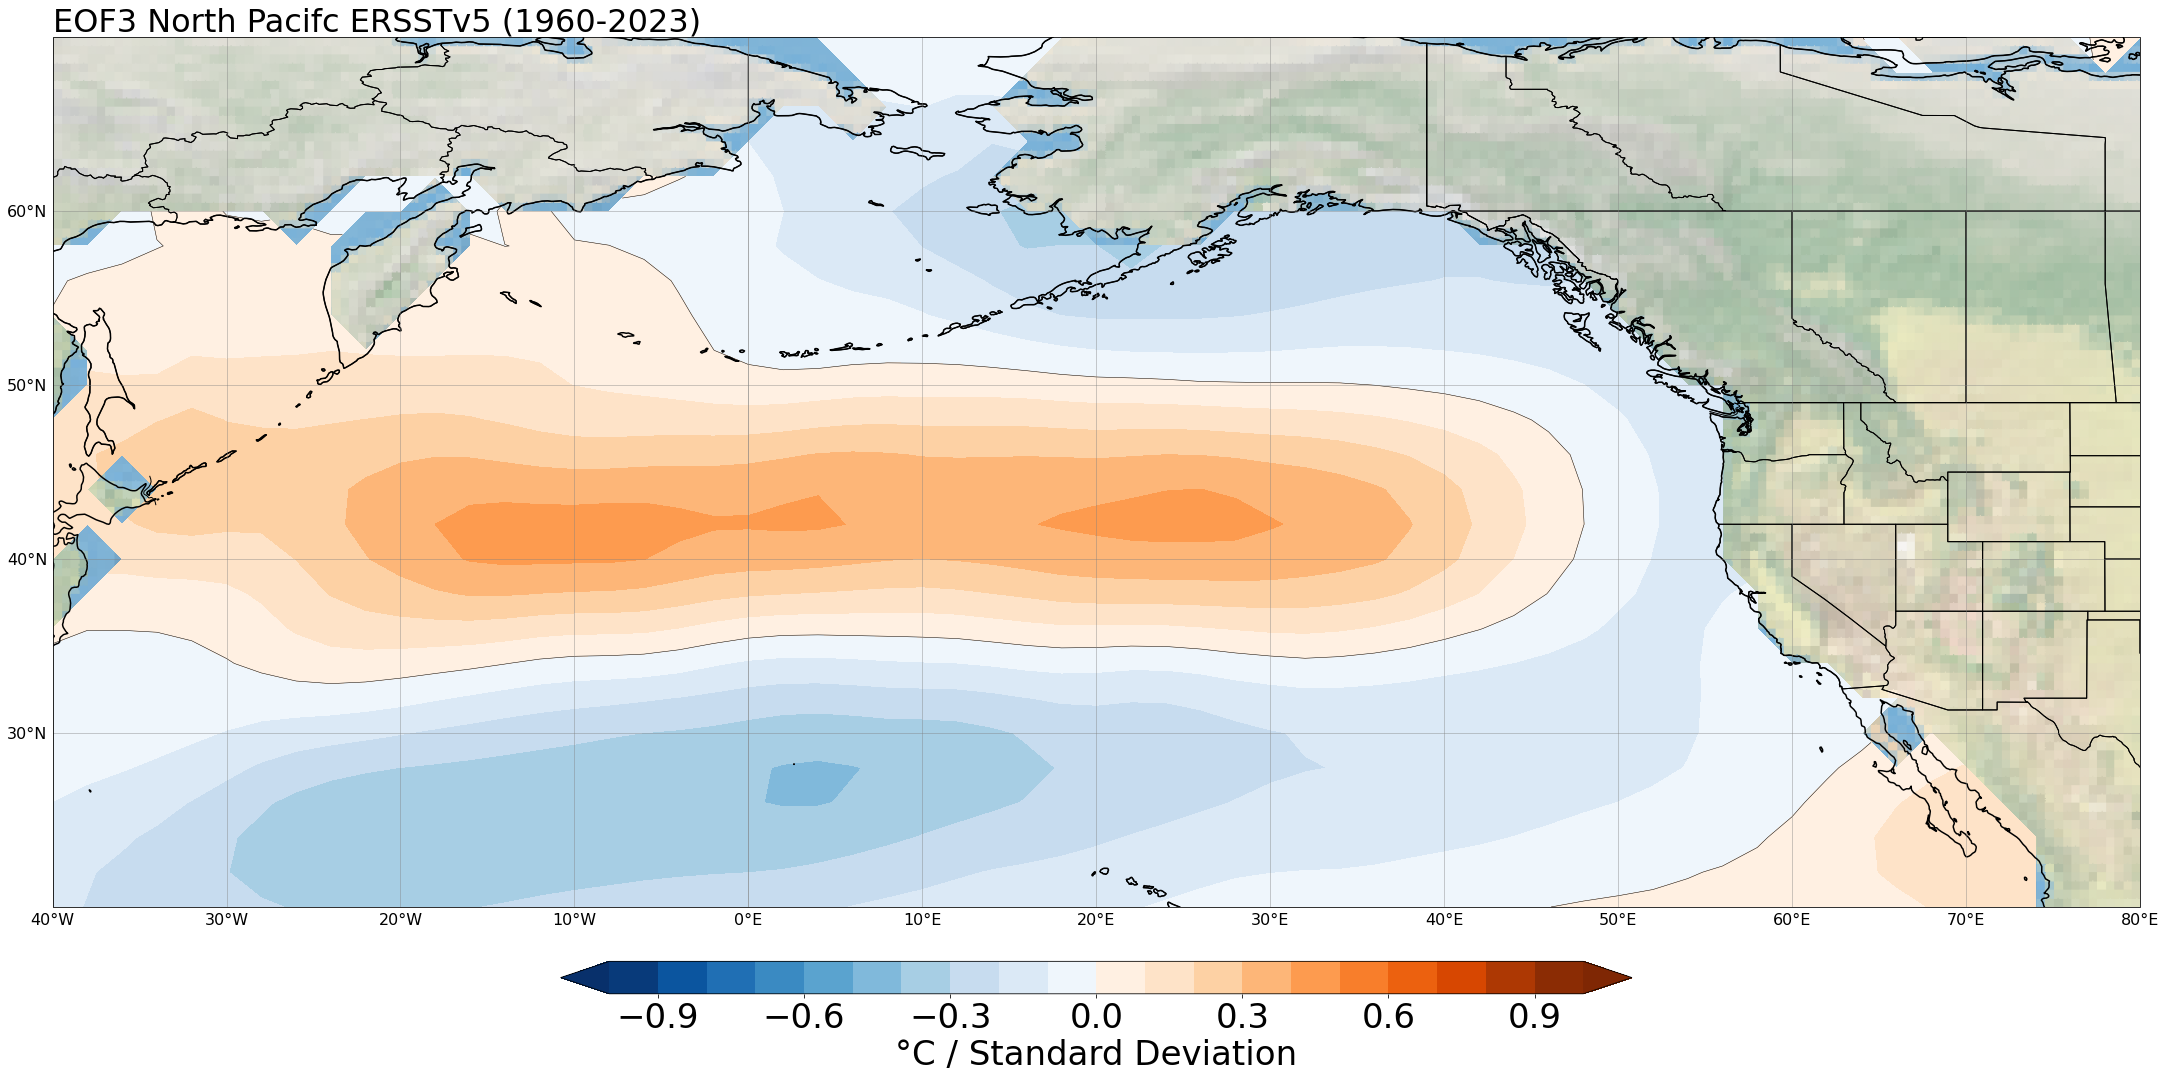

In [38]:
fig, ax = create_map_background()

bottom = cm.get_cmap('Oranges', 128)
top = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 50)),
                       bottom(np.linspace(0, 1, 50))))

newcmp = ListedColormap(newcolors, name='OrangeBlue')

css = plt.contourf(lonsEOF, latsEOF, dnplot_3,
                 levels = np.arange(-1, 1.1, .1),  # Adjust levels appropriately
                 cmap=newcmp,
                 transform=ccrs.PlateCarree(),  # specify the data's projection
                 extend='both')

cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,
                    extend ='both')

#Set the colorbar tick label size
cbar.ax.tick_params(labelsize=34) 

cbar.ax.set_xlabel('°C / Standard Deviation', fontsize = 34)

contourdifSSTglobeAnomaly = plt.contour(lonsEOF, latsEOF, dnplot_3, 
                             levels=np.arange(-1, 1, 1),  # Choose appropriate contour levels
                             linestyles='-', linewidths=0.5, colors='k',
                             transform=ccrs.PlateCarree())

plt.title(f'EOF3 North Pacifc ERSSTv5 (1960-2023)', loc='left',fontsize = 32)
#plt.title(f'Product By: Cameron Masiello', loc='right',fontsize = 32)

In [39]:
#This calculates the EOF in terms of °C/Standard Deviation of SST Anomaly Data
eof_num = 4  # Index for the first EOF and PC

#Retrieve the original field data (this should be the data in units of °C before detrending and normalization)
#It's important that this data has the same spatial and temporal dimensions as the 'weighted_field' used in eof_spatial_analysis
state_orig = sst_anomalies.values  # 'original_field' should be the original SST data in °C
a, b, c = state_orig.shape

#Flatten the original state for projection
state_orig_flat = state_orig.reshape(a, b*c)

#Select the corresponding PC for the EOF pattern you want to visualize and standardize it
pc = pcs[:, eof_num - 1]
pc_std = (pc - np.mean(pc)) / np.std(pc)

#Project the standardized PC onto the EOF pattern
dn = (1.0 / np.size(state_orig_flat, axis=0)) * np.dot(pc_std, state_orig_flat)

#Reshape the result back to the original spatial dimensions
dnplot_4 = dn.reshape(b, c)

/var/folders/d_/plphgc7j2qdgppj6smtbjncc0000gn/T/ipykernel_2304/3940875634.py:17: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,


Text(0.0, 1.0, 'EOF4 North Pacifc ERSSTv5 (1960-2023)')

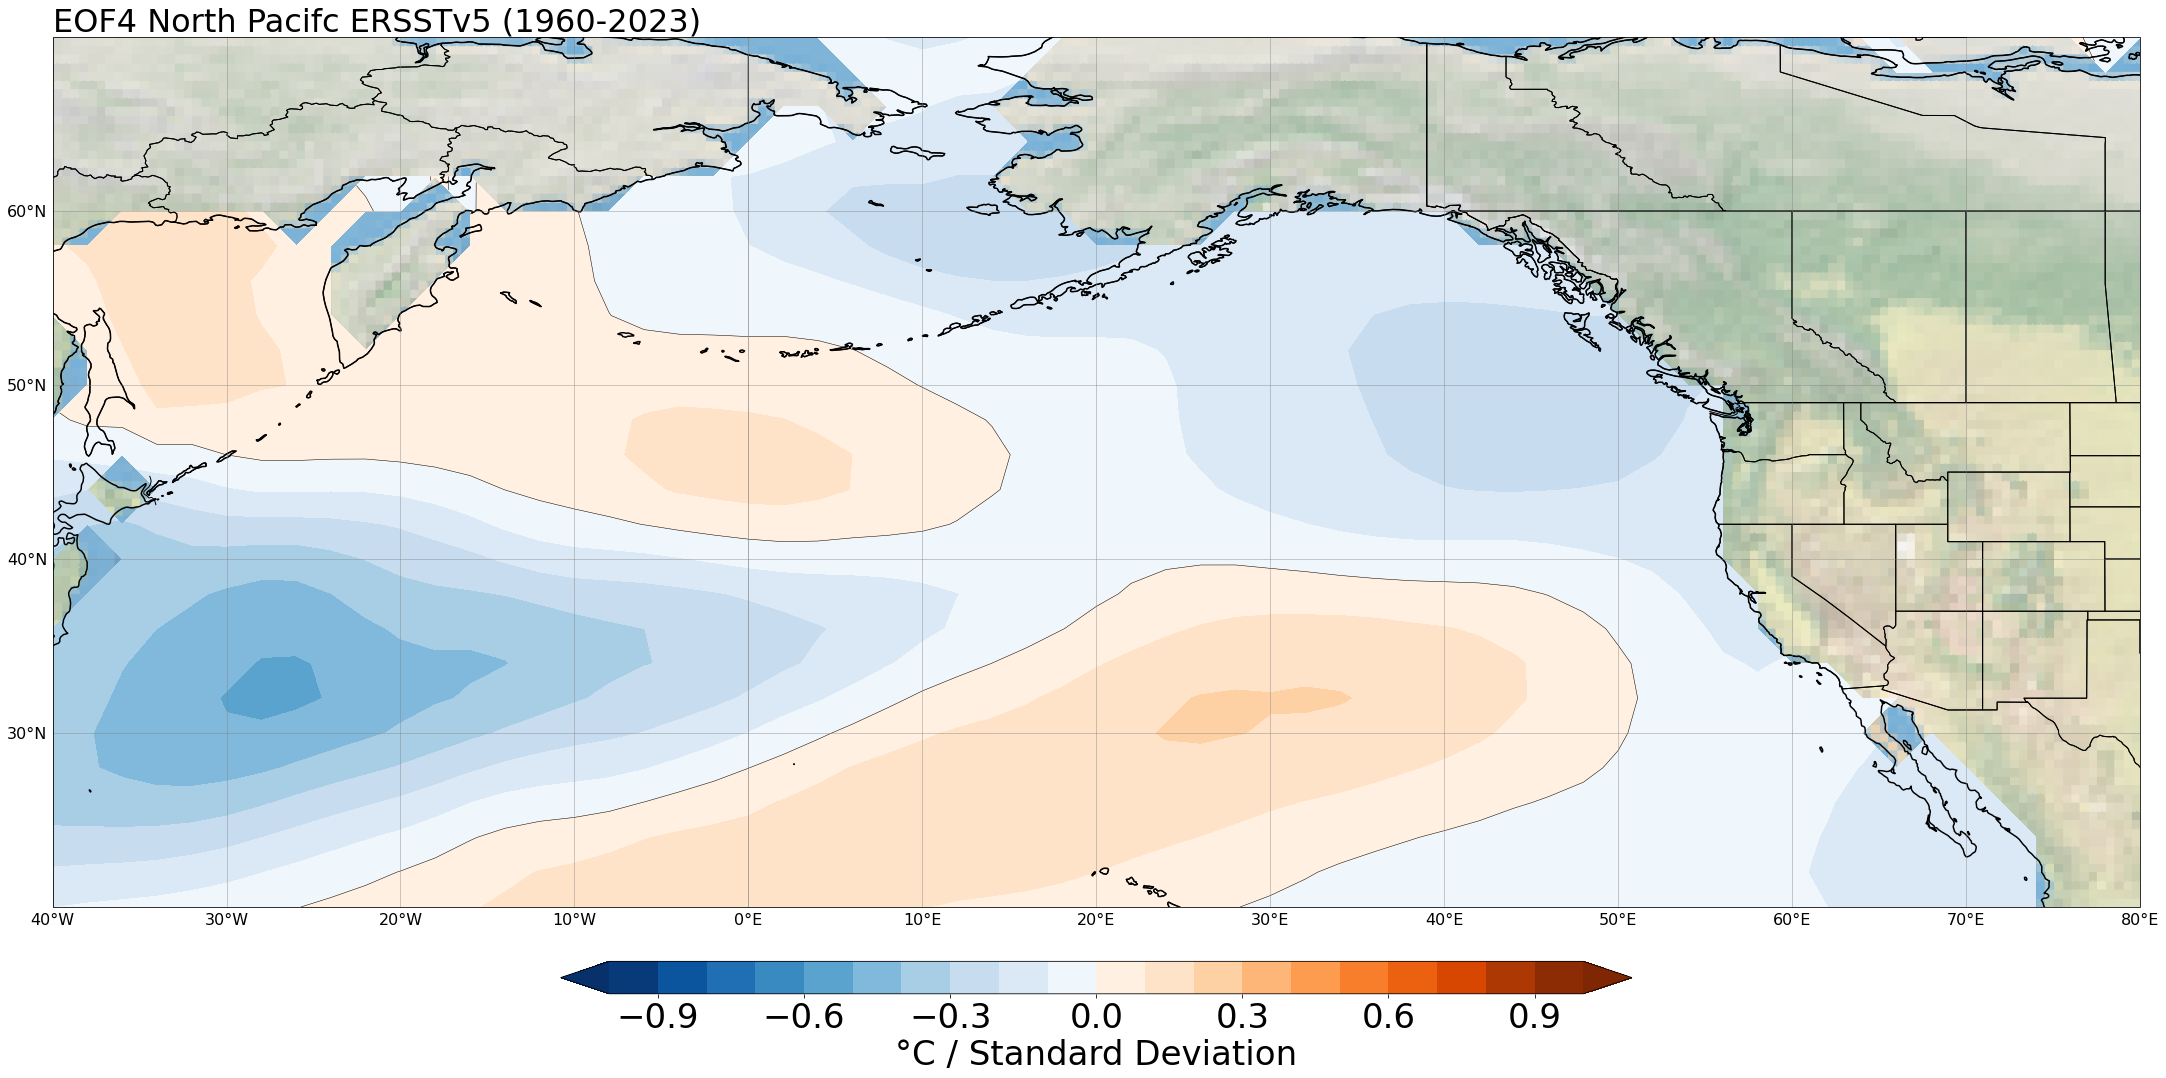

In [40]:
fig, ax = create_map_background()

bottom = cm.get_cmap('Oranges', 128)
top = cm.get_cmap('Blues_r', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 50)),
                       bottom(np.linspace(0, 1, 50))))

newcmp = ListedColormap(newcolors, name='OrangeBlue')

css = plt.contourf(lonsEOF, latsEOF, dnplot_4,
                 levels = np.arange(-1, 1.1, .1),  # Adjust levels appropriately
                 cmap=newcmp,
                 transform=ccrs.PlateCarree(),  # specify the data's projection
                 extend='both')

cbar = plt.colorbar(css, orientation='horizontal', pad=0.05, shrink=0.3, aspect=30,
                    extend ='both')

#Set the colorbar tick label size
cbar.ax.tick_params(labelsize=34) 

cbar.ax.set_xlabel('°C / Standard Deviation', fontsize = 34)

contourdifSSTglobeAnomaly = plt.contour(lonsEOF, latsEOF, dnplot_4, 
                             levels=np.arange(-1, 1, 1),  # Choose appropriate contour levels
                             linestyles='-', linewidths=0.5, colors='k',
                             transform=ccrs.PlateCarree())

plt.title(f'EOF4 North Pacifc ERSSTv5 (1960-2023)', loc='left',fontsize = 32)
#plt.title(f'Product By: Cameron Masiello', loc='right',fontsize = 32)